# Entrenar modelos iniciales

## Importar

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Features

In [4]:
image_dir = 'Images'

features = {}

for img_name in os.listdir(image_dir):
    filename = os.path.join(image_dir, img_name)
    
    # Cargar y procesar imagen
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extraer características
    feature = model.predict(image, verbose=0)
    img_id = img_name.split('.')[0]  # ejemplo: '123456' de '123456.jpg'
    features[img_id] = feature.flatten()


In [5]:
import pickle
with open("features_ResNet50.pkl", "wb") as f:
    pickle.dump(features, f)

## Captions

In [ ]:
caption_path = 'captions.txt'
descriptions = {}

with open(caption_path, 'r') as file:
    next(file)  # Saltar encabezado
    for line in file:
        tokens = line.strip().split(',')
        img_id, caption = tokens[0], tokens[1]
        img_id = img_id.split('.')[0]
        if img_id not in descriptions:
            descriptions[img_id] = []
        # Puedes agregar tokens especiales para entrenar el modelo
        descriptions[img_id].append('startseq ' + caption + ' endseq')

In [ ]:
import string

def clean_captions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, caps in descriptions.items():
        new_caps = []
        for caption in caps:
            caption = caption.lower()
            caption = caption.translate(table)
            caption = caption.split()
            caption = [word for word in caption if len(word) > 1 and word.isalpha()]
            new_caps.append(' '.join(caption))
        descriptions[key] = new_caps

clean_captions(descriptions)

In [ ]:
import pickle

with open("descriptions.pkl", "wb") as f:
    pickle.dump(descriptions, f)

## Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer

# Crear lista de todas las descripciones
all_captions = []
for key in descriptions:
    all_captions.extend(descriptions[key])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Guardar tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

## Cargar modelos y funciones necesarias

In [3]:
import pickle

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Cargar features
with open("features_ResNet50.pkl", "rb") as f:
    features = pickle.load(f)

# Cargar descripciones
with open("descriptions.pkl", "rb") as f:
    descriptions = pickle.load(f)

vocab_size = len(tokenizer.word_index) + 1

def max_length(descriptions):
    return max(len(d.split()) for desc in descriptions.values() for d in desc)

max_len = max_length(descriptions)
print("Vocab size:", vocab_size)
print("Max caption length:", max_len)


from tensorflow.keras.utils import pad_sequences, to_categorical
import numpy as np

def data_generator(descriptions, features, tokenizer, max_len, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key])
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1
                    if n == batch_size:
                        yield ([np.array(X1), np.array(X2)], np.array(y))
                        X1, X2, y = [], [], []
                        n = 0


Vocab size: 8574
Max caption length: 34


# Modelo Red

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Imagen
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Texto
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Fusionar
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              2194944   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

## Train Model

In [5]:
#Forma video
import time  

epochs = 30
batch_size = 64


steps = sum(len(c) for c in descriptions.values()) // batch_size

start_time = time.time()

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    generator = data_generator(descriptions, features, tokenizer, max_len, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
# Guardar el modelo entrenado
model.save("caption_model_ResNet50.h5")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

Epoch 1/30
632/632 [==============================] - 98s 144ms/step - loss: 5.5826
Epoch 2/30
632/632 [==============================] - 70s 110ms/step - loss: 4.5278
Epoch 3/30
632/632 [==============================] - 71s 112ms/step - loss: 4.0946
Epoch 4/30
632/632 [==============================] - 69s 110ms/step - loss: 3.7763
Epoch 5/30
632/632 [==============================] - 73s 115ms/step - loss: 3.5322
Epoch 6/30
632/632 [==============================] - 74s 117ms/step - loss: 3.3134
Epoch 7/30
632/632 [==============================] - 78s 123ms/step - loss: 3.1187
Epoch 8/30
632/632 [==============================] - 72s 114ms/step - loss: 2.9466
Epoch 9/30
632/632 [==============================] - 73s 116ms/step - loss: 2.7909
Epoch 10/30
632/632 [==============================] - 77s 122ms/step - loss: 2.6586
Epoch 11/30
632/632 [==============================] - 74s 117ms/step - loss: 2.5586
Epoch 12/30
632/632 [==============================] - 77s 121ms/step - lo

c:\Users\WD\.conda\envs\tf_gpu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Cargar Modelo

In [6]:
from tensorflow.keras.models import load_model

# Cargar el modelo desde el archivo
model = load_model("caption_model_ResNet50.h5")

# Verificar el resumen del modelo
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              2194944   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

# Generar Captions

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_caption(model, tokenizer, photo, max_len):
    in_text = 'startseq'
    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq ', '').replace(' endseq', '')

In [13]:
img_id = '1000268201_693b08cb0e' 
photo = features[img_id]
photo = photo.reshape((1, 2048 ))

caption = generate_caption(model, tokenizer, photo, max_len=34)  # usa el max_len que calculaste antes
print("Predicción:", caption)

Predicción: woman in pink dress with climbing into wooden stairs held by stairs


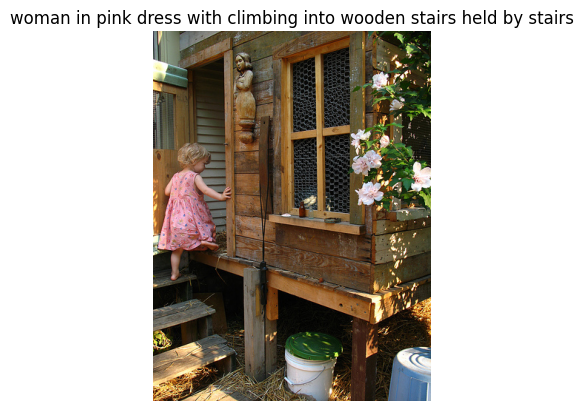

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen original
image_path = f"Images/{img_id}.jpg"

# Mostrar imagen + caption
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()

# Probar Modelo

BLEU (Bilingual Evaluation Understudy)

mide cuánto se parecen tus captions generadas a las captions reales, comparando n-gramas (secuencias de palabras).

BLEU	Evalúa...	Interpretación
BLEU-1	unigramas (1 palabra)	¿Usaste palabras correctas?
BLEU-2	bigramas (pares)	¿Palabras correctas en orden?
BLEU-3	trigramas	¿Frases cortas correctas?
BLEU-4	4-gramas	¿Frases completas coherentes?

In [16]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

test_keys = list(features.keys())[:1000]  # o usa un subset específico
actual, predicted = list(), list()

for key in tqdm(test_keys):
    # Obtener captions reales
    references = descriptions[key]  # Lista de captions
    references = [caption.split() for caption in references]  # tokenizar

    # Predecir caption
    photo = features[key].reshape((1, 2048 ))
    y_pred = generate_caption(model, tokenizer, photo, max_len)
    y_pred = y_pred.split()

    actual.append(references)
    predicted.append(y_pred)

# Calcular BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

100%|██████████| 1000/1000 [08:25<00:00,  1.98it/s]


BLEU-1: 0.363395
BLEU-2: 0.215636
BLEU-3: 0.140402
BLEU-4: 0.092832


Esto significa:

Modelo elige palabras correctas (BLEU-1 = 42%) bastante bien.

A medida que aumentas la exigencia de secuencias más largas (BLEU-2 a BLEU-4), la precisión baja, lo cual es normal.

Un BLEU-4 entre 10–20% es típico en modelos básicos de image captioning, sin atención ni técnicas más avanzadas.

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_prediction(image_name, model, tokenizer, features, descriptions, max_length, base_dir="Images"):
    # Obtener ID de imagen sin .jpg
    image_id = image_name.split('.')[0]
    
    # Ruta a la imagen
    img_path = os.path.join(base_dir, image_name)
    
    # Abrir imagen
    image = Image.open(img_path)

    # Mostrar captions reales
    print("\n------------------ Actual Captions ------------------")
    for caption in descriptions[image_id]:
        print(caption)

    # Predecir
    photo = features[image_id].reshape((1, 2048 ))
    y_pred = generate_caption(model, tokenizer, photo, max_length)
    
    print("\n------------------ Predicted Caption ------------------")
    print(y_pred)

    # Mostrar imagen
    plt.imshow(image)
    plt.axis('off')
    plt.title(y_pred, fontsize=10)
    plt.show()


------------------ Actual Captions ------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq

------------------ Predicted Caption ------------------
woman in pink dress with climbing into wooden stairs held by stairs


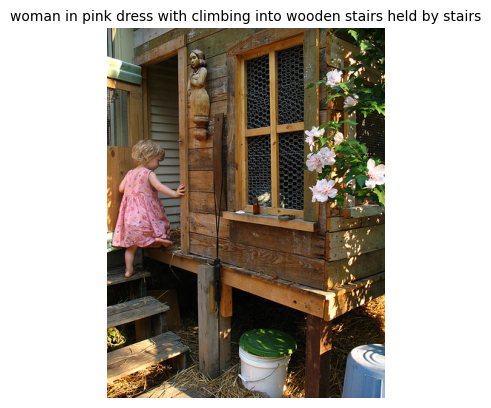

In [18]:
show_prediction("1000268201_693b08cb0e.jpg", model, tokenizer, features, descriptions, max_len)



------------------ Actual Captions ------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tricolored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq

------------------ Predicted Caption ------------------
two dogs wrestle with each other


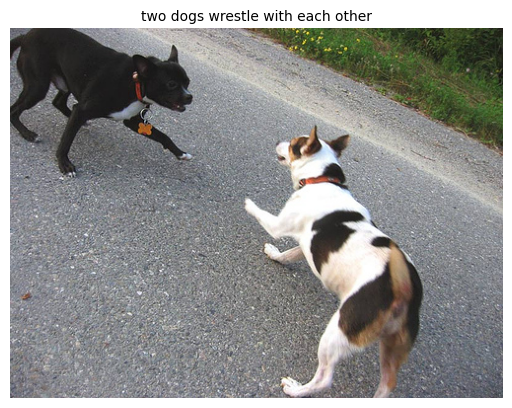

In [19]:
show_prediction("1001773457_577c3a7d70.jpg", model, tokenizer, features, descriptions, max_len)



------------------ Actual Captions ------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq

------------------ Predicted Caption ------------------
there is girl on large painted bike


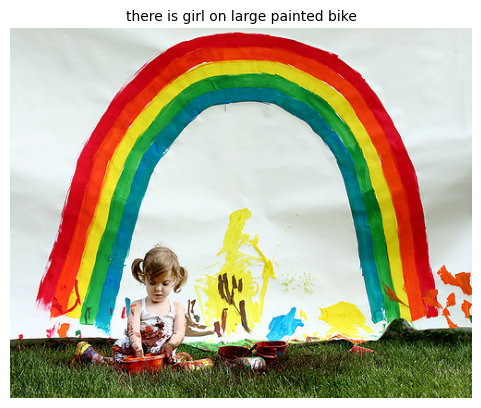

In [20]:
show_prediction("1002674143_1b742ab4b8.jpg", model, tokenizer, features, descriptions, max_len)


# Mejorando modelo